# Import Library

In [40]:
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from omegaconf import OmegaConf


In [10]:
parent_dir = Path().resolve().parent
print(f"current dir: {parent_dir}")

current dir: C:\Code\Python_Code\analysis_brain_data


# Read Config

In [16]:
config = OmegaConf.load("config\\analysis.yaml")

brain_data_path = parent_dir / Path(config.paths.brain_data_path)
print(brain_data_path)

C:\Code\Python_Code\analysis_brain_data\data\mori_metric.csv


# Load Data And Processing

In [17]:
data = pd.read_csv(brain_data_path)
data.head()

,#時刻,脳血流(左),脳血流(左).1,脳血流(右),脳血流(右).1,脈拍(左),脈拍(右),M1,M2,M3,M4,M5,M6
0,6.7,0.015396,-0.085795,-0.097502,-0.212056,78.639080,68.870546,1,0,0,0,0,0
1,6.8,0.013827,-0.087364,-0.097118,-0.211672,78.065310,69.031466,0,0,0,0,0,0
2,6.9,0.013867,-0.087324,-0.096264,-0.210818,77.654451,69.113290,0,0,0,0,0,0
3,7.0,0.013740,-0.087451,-0.095291,-0.209845,77.699429,69.525719,0,0,0,0,0,0
4,7.1,0.012943,-0.088248,-0.094801,-0.209355,77.412203,70.080115,0,0,0,0,0,0


In [29]:
data_drop = data.drop(columns=["脳血流(左)", "脳血流(右)"])
data_rename = data_drop.rename(columns={"#時刻": "時刻", "脳血流(左).1": "脳血流(左)_shift", "脳血流(右).1": "脳血流(右)_shift"})
data_rename.head()

,時刻,脳血流(左)_shift,脳血流(右)_shift,脈拍(左),脈拍(右),M1,M2,M3,M4,M5,M6
0,6.7,-0.085795,-0.212056,78.639080,68.870546,1,0,0,0,0,0
1,6.8,-0.087364,-0.211672,78.065310,69.031466,0,0,0,0,0,0
2,6.9,-0.087324,-0.210818,77.654451,69.113290,0,0,0,0,0,0
3,7.0,-0.087451,-0.209845,77.699429,69.525719,0,0,0,0,0,0
4,7.1,-0.088248,-0.209355,77.412203,70.080115,0,0,0,0,0,0


In [30]:
split_index = []

for i, (idx, row) in enumerate(data_rename.iterrows()):
    for m in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6']:
        if row[m] == 1:
            # M1~M6に1があった場合、その行を新しいデータフレームに追加
            split_index.append(i)

print(f"split_indexs: {split_index}")

split_indexs: [0, 409, 809, 1211]


In [ ]:
split_dataset = {
    "zero_back_1": data_rename.iloc[split_index[0]:split_index[1]],
    "two_back": data_rename.iloc[split_index[1]:split_index[2]],
    "zero_back_2": data_rename.iloc[split_index[2]:split_index[3]],
    }

# Plot Data

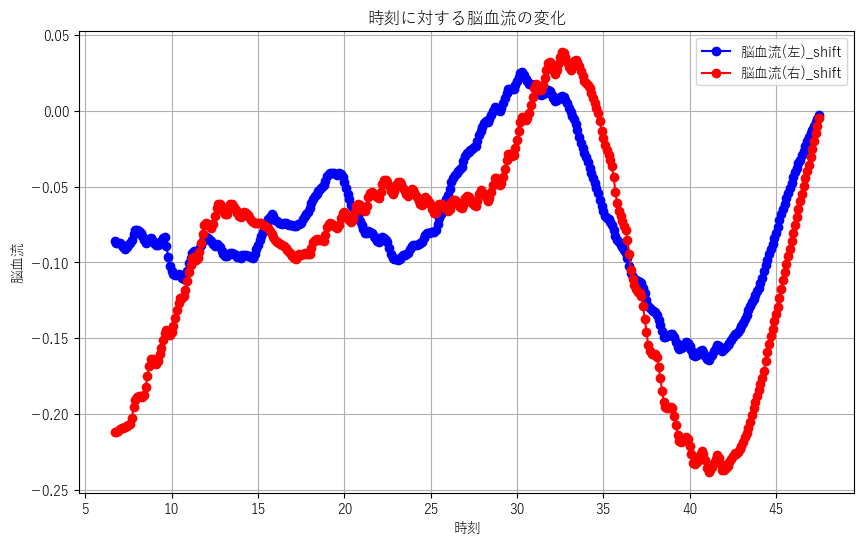

In [ ]:
matplotlib.rcParams['font.family'] = 'Yu Gothic' # 日本語フォントを設定

plt.figure(figsize=(10, 6))

# 左右の脳血流をプロット
plt.plot(zero_back_1['時刻'], zero_back_1['脳血流(左)_shift'], label='脳血流(左)_shift', color='blue', marker='o')
plt.plot(zero_back_1['時刻'], zero_back_1['脳血流(右)_shift'], label='脳血流(右)_shift', color='red', marker='o')

# グラフのラベルとタイトル
plt.xlabel('時刻')
plt.ylabel('脳血流')
plt.title('時刻に対する脳血流の変化')

# 凡例
plt.legend()

# グラフを表示
plt.grid(True)
plt.show()

# LinearRegression

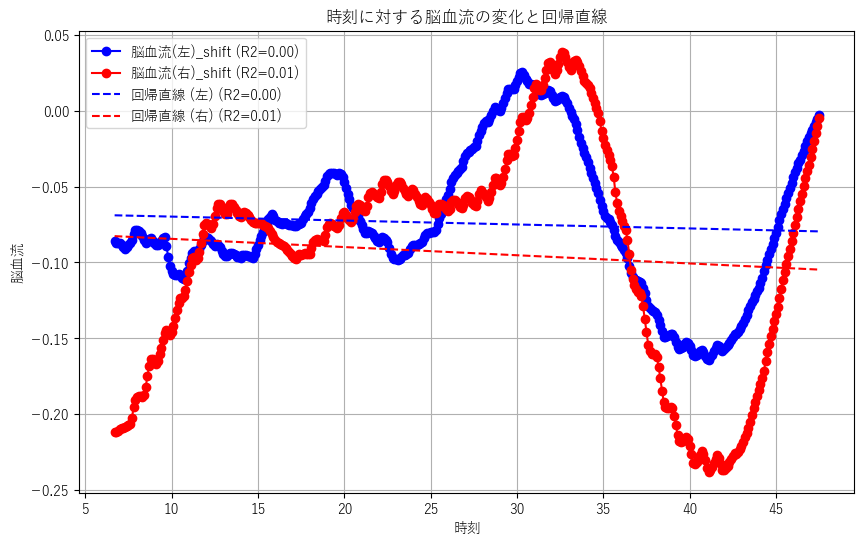

In [41]:
# 線形回帰モデルの作成
X = zero_back_1['時刻'].values.reshape(-1, 1)  # 時刻
y_left = zero_back_1['脳血流(左)_shift'].values  # 脳血流(左)_shift
y_right = zero_back_1['脳血流(右)_shift'].values  # 脳血流(右)_shift

# 左右のデータに対して線形回帰を適用
model_left = LinearRegression()
model_right = LinearRegression()

model_left.fit(X, y_left)
model_right.fit(X, y_right)

# 回帰直線の予測
y_pred_left = model_left.predict(X)
y_pred_right = model_right.predict(X)

# 決定係数（R2）の計算
r2_left = r2_score(y_left, y_pred_left)
r2_right = r2_score(y_right, y_pred_right)

# プロット
plt.figure(figsize=(10, 6))

# 左右の脳血流をプロット
plt.plot(zero_back_1['時刻'], zero_back_1['脳血流(左)_shift'], label=f'脳血流(左)_shift (R2={r2_left:.2f})', color='blue', marker='o')
plt.plot(zero_back_1['時刻'], zero_back_1['脳血流(右)_shift'], label=f'脳血流(右)_shift (R2={r2_right:.2f})', color='red', marker='o')

# 回帰直線をプロット
plt.plot(zero_back_1['時刻'], y_pred_left, label=f'回帰直線 (左) (R2={r2_left:.2f})', color='blue', linestyle='--')
plt.plot(zero_back_1['時刻'], y_pred_right, label=f'回帰直線 (右) (R2={r2_right:.2f})', color='red', linestyle='--')

# グラフのラベルとタイトル
plt.xlabel('時刻')
plt.ylabel('脳血流')
plt.title('時刻に対する脳血流の変化と回帰直線')

# 凡例
plt.legend()

# グラフを表示
plt.grid(True)
plt.show()